### Duplicate detection

This notebook performs the duplicate detection method to identify near-exact duplicates defined as groups of songs whose lyrics are highly similar. The song lyrics in the WASABI database were collected from websites where user writes the lyrics and there is no standard for them. This lead to the possibility that two lyrics may be reported differently due to minimal edits, despite being from the same song.

On the other hand, at this point we are not interested in identifying song lyrics with slight adaptations because these can be considered as different songs.

In [1]:
# mount GDrive
from google.colab import drive
#drive.mount('/content/drive')
drive._mount('/content/drive')

Mounted at /content/drive


In [2]:
# load dataset_10
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_group_decades" .
!cp -r "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10/data_lyrics_person_decades" .

In [3]:
%pylab inline
import pandas as pd
import glob
import re
from scipy import sparse
from tqdm import tqdm

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

from tqdm.notebook import tqdm
import nltk

tqdm.pandas()

Populating the interactive namespace from numpy and matplotlib


In [4]:
# get number of songs across time

data_folders = ['data_lyrics_person_decades/', 'data_lyrics_group_decades/']

song_lyrics = []

for data_folder in data_folders:
    type_ = data_folder.split('_')[-2]
    for file in glob.glob(data_folder+'*_[!.]*.json.gz'): # skip songs with no dates

        data_chunk = pd.read_json(file, orient='records', lines=True, chunksize=5000 )
        for chunk in data_chunk:        

            chunk = chunk[['song_id', 'song_title', 'language_detect', 'lyrics', 'n_words', 'n_lines', 'artist_id', 'artist_name',
                            'song_pubdate_combined', 'song_year_combined', 'song_decade_combined', 'other_artist_info']]
            song_lyrics.append(chunk)

song_lyrics = pd.concat(song_lyrics)
print('Total number of song lyrics: ', song_lyrics.shape[0])
song_lyrics.head()

Total number of song lyrics:  460339


,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info
0,5714dec325ac0d8aee380b13,Tears All Over Town,english,Ride the subway home\nPretend that you're not ...,192,33,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
1,5714dec325ac0d8aee380b14,Kathleen,english,If I don't laugh i'll cry\nAt all the years go...,201,39,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
2,5714dec325ac0d8aee380b15,Girls Can Really Tear You Up Inside,english,There's a girl whose stuck inside a picture fr...,233,38,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
3,5714dec325ac0d8aee380b16,The Long Goodbye,english,You stormed my winter palace\nYou rid my heart...,202,36,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."
4,5714dec325ac0d8aee380b17,Somebody Hurt You,english,Boy\nSomebody hurt you\nBoy\nI wish I knew who...,210,42,56d7e9416b60c09814f93eb7,A Girl Called Eddy,2004-08-10,2004,2000,"{'n_albums': 2, 'n_songs': 16, 'languages': {'..."


In [5]:
# is song_id unique?
song_lyrics.song_id.duplicated().any()

False

In [6]:
# are there exact duplicated lyrics? How many?
song_lyrics.lyrics.duplicated().sum()

87699

In [7]:
# remove them. How may unique?
exact_duplicated_lyrics = song_lyrics[song_lyrics.lyrics.duplicated(False)]
song_lyrics = song_lyrics.sort_values("song_year_combined").drop_duplicates(subset=['lyrics'], keep='first')

print('N lyrics: ', song_lyrics.shape[0])
print("N unique with exact duplicate: ", exact_duplicated_lyrics.drop_duplicates(subset=['lyrics']).shape[0])

N lyrics:  372640
N unique with exact duplicate:  57194


In [8]:
# reset index and set its name to "row"
# This will be the index used in the following
song_lyrics = song_lyrics.reset_index(drop=True)
song_lyrics.index.name = 'row'
song_lyrics = song_lyrics.reset_index()

song_lyrics.head(2)

,row,song_id,song_title,language_detect,lyrics,n_words,n_lines,artist_id,artist_name,song_pubdate_combined,song_year_combined,song_decade_combined,other_artist_info
0,0,5714dee125ac0d8aee4f71d5,Hey Pretty Baby,english,"Hey pretty baby, I need your love\nUnderneath ...",199,29,56d961adcc2ddd0c0f6ba28d,Ricky Nelson,,1960,1960,"{'n_albums': 39, 'n_songs': 554, 'languages': ..."
1,1,5714ded025ac0d8aee41c826,So Used To Loving You,english,So used to loving you I can't believe we're th...,87,9,56d82dc853a7ddfc01f94d8a,Ferlin Husky,,1960,1960,"{'n_albums': 34, 'n_songs': 396, 'languages': ..."


### Count vectorizer

In the following, we represent each lyrics as a bag of 3-grams. The similarity is then computed based on this representation

In [9]:
# additional set of stopwords occurring in lyrics
STOPWORDS = ENGLISH_STOP_WORDS.union(set(['oh', 'yeah', 'la', 'hey', 'na', 'ha', 'ooh', 'ah', 'da', 'uh', 'yo',
 'whoa', 'huh', 'doo', 'yea', 'ba', 'ya', 'oooh', 'ohh']))

In [10]:
# basic cleaning of lyrics
def lyrics_iterator(lyrics):
    
    for lyric in lyrics:
        lyric = re.sub("\d+", " ", lyric) # remove numbers
        lyric = lyric.replace("\n", " ").lower() # replace newline characters
        lyric = " ".join(lyric.split()) # remove additional spaces

        tokens = lyric.split() 
        # avoid sequence of repeated words
        tokens = [tokens[0]] + [post for pre, post in zip(tokens[:-1], tokens[1:]) if post!=pre]
        lyric = " ".join(tokens)
        yield lyric

In [11]:
# count all 3-grams (words longer than 3 characters), removing stopwords

CountVect = CountVectorizer(stop_words=STOPWORDS,
                           ngram_range=(3, 3),
                           min_df=2, 
                            #max_df=0.9, # 3grams occurring in more than 90% of lyrics are discarded
                            binary=True, # return binary sparse BoW matrix
                            token_pattern=r"(?u)\b\w\w{2,}\b") # keep only words longer than 2 characters
X = CountVect.fit_transform(lyrics_iterator(song_lyrics.lyrics))
X

<372640x2767546 sparse matrix of type '<class 'numpy.int64'>'
	with 9445589 stored elements in Compressed Sparse Row format>

In [12]:
# the ngrams with repeated tokens are because of for example:
# "I love you, I love you, I love you" -> "love love love"
np.array(CountVect.get_feature_names())[np.asarray(X.sum(axis=0)).flatten().argsort()[::-1]][:40]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['love love love', 'don know don', 'know don know',
       'dreams come true', 'know know know', 'just don know',
       'come come come', 'long time ago', 'don know just',
       'new york city', 'make feel like', 'don know love',
       'don know know', 'just little bit', 'dream come true',
       'baby baby baby', 'love don know', 'don know got', 'baby don know',
       'don know say', 'let let let', 'time time time', 'don want don',
       'want want want', 'long long time', 'ain got time', 'don care don',
       'cause don know', 'like don know', 'don want know',
       'just don care', 'want don want', 'got got got', 'know love love',
       'don know going', 'don wanna hear', 'right right right',
       'say say say', 'make feel good', 'don know gonna'], dtype='<U70')

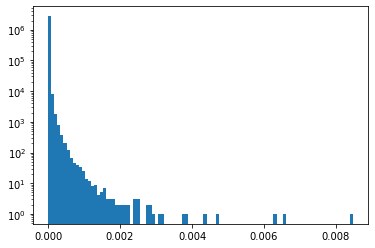

In [13]:
# distribution of frac of lyrics in which an n-gram occurs
plt.hist(np.asarray(X.sum(axis=0)).flatten() / X.shape[0], bins=100);
plt.yscale('log')

In [14]:
# save the fitted count vectorizer and delete it
import pickle
with open('CountVect_3grams.pkl', 'wb') as fout:
    pickle.dump(CountVect, fout)

del CountVect

sparse.save_npz("3gram_matrix.npz", X)
song_lyrics[['row', 'song_id']].to_json("3gram_matrix_row_songs.json", orient='records', lines=True)

In [15]:
# get some statistics, such as the number of features representing a lyrics in X respect to the total number

def count_ngrams(lyric, n, pattern=r"(?u)\b\w\w{2,}\b"):

    lyric = re.sub("\d+", " ", lyric)
    lyric = lyric.replace("\n", " ").replace("´", "’").replace("'", "’").lower()
    lyric = " ".join(lyric.split())

    tokens = lyric.split()
    # avoid sequence of repeated words
    tokens = [tokens[0]] + [post for pre, post in zip(tokens[:-1], tokens[1:]) if post!=pre]
    lyric = " ".join(tokens)

    tokens = re.findall(pattern, lyric)
    tokens = [tok for tok in tokens if tok not in STOPWORDS]

    if len(tokens)<n:
        n_unique_ngrams = 0
    else:
        unique_ngrams = set(nltk.ngrams(tokens, n))
        n_unique_ngrams = len(unique_ngrams)

    return n_unique_ngrams

# compute the stats
song_lyrics.loc[:, 'n_ngrams'] = song_lyrics.lyrics.apply(lambda l: count_ngrams(l, 3))
song_lyrics.loc[:, 'n_ngrams_in_X'] = np.asarray(X.sum(axis=1)).flatten().tolist()
song_lyrics.loc[:, 'ngram_represent_ratio'] = (song_lyrics.n_ngrams_in_X / song_lyrics.n_ngrams).values

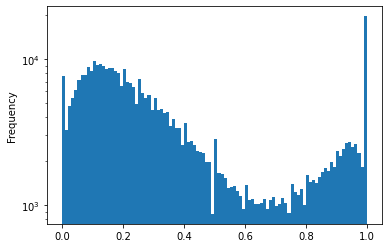

In [16]:
song_lyrics.loc[:, 'ngram_represent_ratio'].plot(kind='hist', bins=100)
plt.yscale('log')

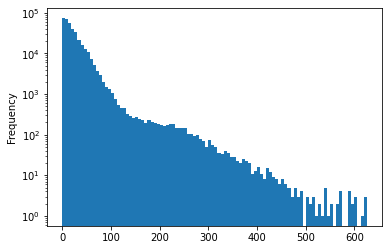

In [17]:
song_lyrics.loc[:, 'n_ngrams_in_X'].plot(kind='hist', bins=100)
plt.yscale('log')

### Compute similarities

Here we compute the similarity between pairs of lyrics as the Jaccard index between the 3-grams of the two lyrics. 

In [18]:
# this represent the number of common n-grams between two lyrics
XXt = X.dot(X.T)
#XXt = awesome_cossim_topn(X.astype(float), X.T.astype(float), ntop=10000, lower_bound=3) # for each row, returns the highest 10000 values and use threshold at 3
XXt

<372640x372640 sparse matrix of type '<class 'numpy.longlong'>'
	with 151198614 stored elements in Compressed Sparse Row format>

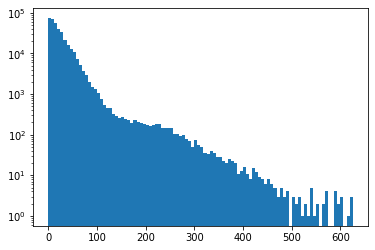

In [19]:
# distribution of diagonal values (aka, number of ngrams of a lyric)
plt.hist(XXt.diagonal(), bins=100);
plt.yscale('log')

In [21]:
# compute the similarities
# we compute also the Sørensen–Dice coefficient and the overlap coefficient

# save this. It is useful to speed up the computation
# it is the number of unique n-grams for each song
SSS = np.asarray(X.sum(axis=1)).flatten()

# compute similarities
similarities = []
n_low_jaccard = 0

# makes this iterable not to run out of memory
# keep only upper triangular matrix and only pairs of songs having more than 5 common n-grams
iterable = filter(lambda item: item[0]<item[1] and item[2]>5, zip(*XXt.nonzero(), XXt.data))

#for i, j in tqdm(zip(*XXt.nonzero()), total=XXt.count_nonzero()):
for i, j, num in tqdm(iterable):

    sss = SSS[[i, j]]
    den_sd = sss.sum()
    sim_sd = 2 * num / den_sd
    if den_sd==0: 
        print(f'Denominator equal to zero at ({i}, {j})...')

    den_oc = sss.min()
    sim_oc = num / den_oc
    if den_oc==0: 
        print(f'Denominator equal to zero at ({i}, {j})...')
    
    # since there is an exact relationship between the sim_sd and the sim_jacc, I compute it
    # computing the jaccard in the for loop requires a lot of time because we need to access the entries of the sparse matrix XXt
    # https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient#Difference_from_Jaccard
    sim_jacc = sim_sd / (2 - sim_sd)

    # threshold at jacc_sim=0.05
    if sim_jacc<=0.05:
        n_low_jaccard += 1
        continue
    
    similarities.append([i, j, num, sim_sd, sim_jacc, sim_oc])

# the table with all the similarities
similarities = pd.DataFrame(similarities, columns=['row', 'col', 'num', 'sim_sd', 'sim_jacc', 'sim_oc'])

similarities = similarities.merge(song_lyrics[['row', 'song_id']], on='row', how='left').rename(columns={'song_id':'song_id_row'})
similarities = similarities.merge(song_lyrics[['row', 'song_id']].rename(columns={'row':'col'}), on='col', how='left').rename(columns={'song_id':'song_id_col'})

# consider that there are a lot more comparisons that were not computed because XXt[i, j]=0
# count how many they are (number of entries in upper triangular minus rows of similarities)
print('Number of all possible pairs: ', (XXt.shape[0]**2 - XXt.shape[0])//2 - similarities.shape[0])
print('Number of similarities computed: ', similarities.shape[0])
print('Number of similarities skipped due to low jaccard: ', n_low_jaccard)
print("Number of similarities not computed: ", 
      (XXt.shape[0]**2 - XXt.shape[0])//2 - similarities.shape[0] - n_low_jaccard)

similarities.head()

0it [00:00, ?it/s]

Number of all possible pairs:  69429808220
Number of similarities computed:  290260
Number of similarities skipped due to low jaccard:  3013
Number of similarities not computed:  69429805207


,row,col,num,sim_sd,sim_jacc,sim_oc,song_id_row,song_id_col
0,1,561,30,1.000000,1.000000,1.000000,5714ded025ac0d8aee41c826,5714deec25ac0d8aee573522
1,2,329492,33,0.846154,0.733333,0.891892,5714ded025ac0d8aee41c825,5714dee725ac0d8aee53e54f
2,2,85082,33,0.846154,0.733333,0.891892,5714ded025ac0d8aee41c825,5714ded125ac0d8aee42d49a
3,2,59838,23,0.686567,0.522727,0.766667,5714ded025ac0d8aee41c825,5714deec25ac0d8aee576b36
4,2,1411,28,0.767123,0.622222,0.777778,5714ded025ac0d8aee41c825,5714dec825ac0d8aee3bb7dd


In [23]:
# save similarities file
similarities.to_json('computed_similarities.json.gz')

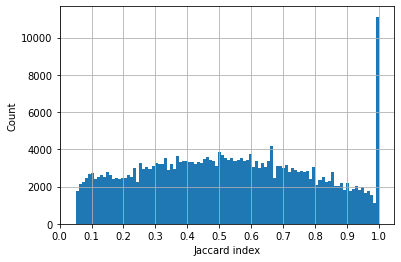

In [24]:
# distribution of jaccard (of pairs evaluated and >0.05)

similarities.sim_jacc.plot(kind='hist', bins=100)
#plt.yscale("log")
plt.xlabel('Jaccard index')
plt.xticks(np.arange(0, 11, 1)/10)
plt.ylabel('Count')
plt.grid();

In [25]:
!mkdir duplicate_detection
!mv *.npz duplicate_detection
!mv *.pkl duplicate_detection
!mv *.json.gz duplicate_detection
!mv *.json duplicate_detection

In [26]:
!cp -r duplicate_detection "drive/MyDrive/Artistic_Content_Creation/WASABI_gender_experiments/WASABI_gender_experiments_definitive/dataset_10" 
